## LA's COVID-19 Reopening Indicators 
This report contains information about how LA County and the City of LA performed yesterday, on a number of key COVID-19 indicators related to the speed at which opening up can occur. Taken together, performing well against the benchmarks provide confidence in moving through each phase of reopening. 

**LA is certainly an epicenter. In late June, LA County Department of Public Health (DPH) [estimated that 1 in 400 people were infectious](https://www.latimes.com/california/story/2020-06-29/o-c-reports-highest-weekly-covid-19-death-toll-as-california-sees-spike-in-cases), asymptomatic, and not isolated. One week later, as of June 29, LA DPH estimated the risk increased threefold, up to [1 in 140](https://www.nytimes.com/2020/06/29/us/california-coronavirus-reopening.html).**

As long as LA consistently tests large portions of its population with fairly low positive COVID-19 results, sustains decreases in cases and deaths, has stable or decreasing COVID-related hospitalizations, and stocks ample available hospital equipment for a potential surge, we are positioned to continue loosening restrictions. When any one indicator fails to meet the benchmark, we should slow down to consider why that is happening. When multiple indicators fail to meet the benchmark, we should pause our reopening plans and even enact more stringent physical and social distancing protocols by moving back a phase.     
    
* [Federal Gating Criteria](https://www.whitehouse.gov/wp-content/uploads/2020/04/Guidelines-for-Opening-Up-America-Again.pdf)
* [State Gating Criteria](https://covid19.ca.gov/roadmap-counties/)
    * CA Department of Public Health: [County Data Chart](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/COVID19CountyDataTable.aspx) and [County Data Monitoring](https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/COVID-19/CountyMonitoringDataStep2.aspx)
* [WHO Testing and Positivity Rate Guidelines](https://coronavirus.jhu.edu/testing/testing-positivity)

Below, you will see how LA performed yesterday on the following indicators. The data does have a one day lag. Whenever City of LA (subset of LA County) data is available, it is also reported.

#### Symptoms
* Downward trajectory of influenza-like illnesses (ILI) reported within a 14-day period **and**
* Downward trajectory of COVID-like syndromic cases reported within a 14-day period

#### Cases
* Downward trajectory of documented cases within a 14-day period **or**
* Downward trajectory of positive tests as a percent of total tests within a 14-day period (flat or increasing volume of tests) 

#### Hospitals
* Treat all patients without crisis care **and**
* Robust testing program in place for at-risk healthcare workers, including emerging antibody testing

### References
* [Reopening Indicators](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/Reopening_Indicators_Comparison.xlsx) from [New York State](https://www.nytimes.com/2020/05/04/nyregion/coronavirus-reopen-cuomo-ny.html) and [Chicago](https://www.chicagotribune.com/coronavirus/ct-coronavirus-chicago-reopening-lightfoot-20200508-ztpnouwexrcvfdfcr2yccbc53a-story.html)
* [Collection of articles](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/reopening-sources.md) related to what experts say about reopening and the known unknowns ahead 
    * [LA and Chicago](https://www.nytimes.com/2020/05/09/us/coronavirus-chicago.html), after NYC, have the most persistent virus caseloads
    * [LA, DC, and Chicago](https://www.latimes.com/california/story/2020-05-22/white-house-concerned-with-coronavirus-spread-in-l-a-area-asks-cdc-to-investigate) remain hotspots within the US 

In [1]:
import numpy as np
import pandas as pd

import utils
import default_parameters
import make_charts
import meet_indicators

from IPython.display import display_html, Markdown 

# Default parameters
county_state_name = default_parameters.county_state_name
state_name = default_parameters.state_name
msa_name = default_parameters.msa_name
time_zone = default_parameters.time_zone

fulldate_format = default_parameters.fulldate_format
monthdate_format = default_parameters.monthdate_format
start_date = default_parameters.start_date
yesterday_date = default_parameters.yesterday_date
today_date = default_parameters.today_date
two_weeks_ago = default_parameters.two_weeks_ago
two_days_ago = default_parameters.two_days_ago
eight_days_ago = default_parameters.eight_days_ago

# Daily testing upper and lower bound
county_test_lower_bound = 15_000
county_test_upper_bound = 16_667
city_test_lower_bound = round(county_test_lower_bound * 0.5)
city_test_upper_bound = round(county_test_upper_bound * 0.5)
positive_lower_bound = 0.04
positive_upper_bound = 0.08
positive_2weeks_bound = 0.05
hospital_bound = 0.30
ca_hospitalization_bound = 0.05

In [2]:
def check_report_readiness(county_state_name, state_name, msa_name, start_date, yesterday_date):
    """
    Check if each dataframe has yesterday's date's info.
    If all datasets are complete, report can be run.
    """
    
    df = utils.prep_county(county_state_name, start_date)
    if df.date.max() < yesterday_date:
        raise Exception("Data incomplete")    
    
    df = utils.prep_lacity_cases(start_date)
    if df.date.max() < yesterday_date:
        raise Exception("Data incomplete")        
    
    df = utils.prep_testing(start_date)
    if df.date.max() < yesterday_date:
        raise Exception("Data incomplete")        
    
    # Sometimes hospital data lags the most...if it has data from 2 days ago, might be ok
    df = utils.prep_lacounty_hospital(start_date)
    if df.date.max() <  two_days_ago:
        raise Exception("Data incomplete")
    
    df = utils.prep_hospital_surge(county_state_name, start_date)
    if df.date.max() < two_days_ago:
        raise Exception("Data incomplete")

check_report_readiness(county_state_name, state_name, msa_name, start_date, yesterday_date)

In [3]:
# Check cases according to some criterion
def check_cases(row):
    status = ["failed" if x < 14 else "met" if x >= 14 else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")

def check_deaths(row):
    status = ["failed" if x < 14 else "met" if x >= 14 else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")

def check_tests(lower_bound, upper_bound, row):
    status = ["failed" if x < lower_bound 
              else "met" if ((x >= lower_bound) and (x < upper_bound)) 
              else "exceeded" if x >= upper_bound 
              else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")

def check_positives(row):
    status = ["failed" if x > positive_upper_bound 
              else "met" if ((x > positive_lower_bound) and (x <= positive_upper_bound)) 
              else "exceeded" if x >= positive_lower_bound 
              else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")

def check_positives_two_weeks(row):
    status = ["met" if x <= positive_2weeks_bound else "failed" for x in row]
    return pd.Series(status, index=row.index, dtype="category")  

def check_hospitals(row):
    status = ["failed" if x < hospital_bound 
              else "met" if x >= hospital_bound 
              else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")    


def check_hospitalizations(row):
    status = ["met" if x < ca_hospitalization_bound 
              else "failed" if x >= ca_hospitalization_bound 
              else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")    


county_fnmap = {
    "Cases": check_cases,
    "Deaths": check_deaths,
    "Daily Testing": lambda row: check_tests(county_test_lower_bound, county_test_upper_bound, row),
    "Positive Tests": check_positives,
    "Positive Tests (WHO)": check_positives_two_weeks,
    "Acute Beds": check_hospitals,
    "ICU Beds": check_hospitals,
    "Ventilators": check_hospitals,
    "COVID Hospitalizations": check_hospitalizations,
    "COVID ICU Hospitalizations": check_hospitalizations,
}

city_fnmap = {
    "Cases": check_cases,
    "Deaths": check_deaths,
    "Daily Testing": lambda row: check_tests(city_test_lower_bound, city_test_upper_bound, row),
    "Positive Tests": check_positives,
    "Positive Tests (WHO)": check_positives_two_weeks,    
    "Acute Beds": check_hospitals,
    "ICU Beds": check_hospitals,
    "Ventilators": check_hospitals,
    "COVID Hospitalizations": check_hospitalizations,
    "COVID ICU Hospitalizations": check_hospitalizations,
}

red = make_charts.maroon
green = make_charts.green
blue = make_charts.blue

stylemap = {
    "failed": f"background-color: {red}; color: white; font-weight: bold; opacity: 0.7" ,
    "met": f"background-color: {green}; color: white; font-weight: bold; opacity: 0.7",
    "exceeded": f"background-color: {blue}; color: white; font-weight: bold; opacity: 0.7",
    "": "background-color: white; color: black; font-weight: bold; opacity: 0.7",
}

In [4]:
def summary_of_indicators():
    # Grab indicators
    county_case_indicator = meet_indicators.meet_case("county", county_state_name, start_date)
    county_death_indicator = meet_indicators.meet_death("county", county_state_name, start_date)
    county_test_indicator = meet_indicators.meet_daily_testing(yesterday_date, "county", 
                                                               county_test_lower_bound, county_test_upper_bound)
    county_positive_indicator = meet_indicators.meet_positive_share(yesterday_date, "county", 
                                                                    positive_lower_bound, positive_upper_bound)
    
    county_positive_2wks_indicator = meet_indicators.meet_positive_share_for_two_weeks(yesterday_date, "county")
    
    acute_indicator = meet_indicators.meet_acute(yesterday_date)
    icu_indicator = meet_indicators.meet_icu(yesterday_date)
    ventilator_indicator = meet_indicators.meet_ventilator(yesterday_date)
    
    hospitalization_indicator = meet_indicators.meet_all_hospitalization(county_state_name, yesterday_date)
    icu_hospitalization_indicator = meet_indicators.meet_icu_hospitalization(county_state_name, yesterday_date)
    

    city_case_indicator = meet_indicators.meet_lacity_case(start_date)
    city_test_indicator = meet_indicators.meet_daily_testing(yesterday_date, "city", 
                                                                   city_test_lower_bound, city_test_upper_bound)
    city_positive_indicator = meet_indicators.meet_positive_share(yesterday_date, "city", 
                                                                  positive_lower_bound, positive_upper_bound)
    
    city_positive_2wks_indicator = meet_indicators.meet_positive_share_for_two_weeks(yesterday_date, "city")

    indicator_names = ["Cases", "Deaths", 
                       "Daily Testing", "Positive Tests", "Positive Tests (WHO)",
                       "Acute Beds", "ICU Beds", "Ventilators", 
                       "COVID Hospitalizations", "COVID ICU Hospitalizations"]
    
    
    # Create separate df for county and city
    county = pd.DataFrame(
        {"LA County": [county_case_indicator, county_death_indicator, 
                    county_test_indicator, county_positive_indicator, county_positive_2wks_indicator,
                    acute_indicator, icu_indicator, ventilator_indicator, 
                    hospitalization_indicator, icu_hospitalization_indicator]},
        index=indicator_names
    )

    city = pd.DataFrame(
        {"City of LA": [city_case_indicator, np.nan, 
                    city_test_indicator, city_positive_indicator, city_positive_2wks_indicator,
                    np.nan, np.nan, np.nan, 
                    np.nan, np.nan]},
        index=indicator_names
    )

    # Style the table
    def display_side_by_side(*args):
        html_str=''
        for df in args:
            html_str+=df
        display_html(html_str.replace('table','table style="display:inline"'),raw=True)
   
        
    county_html = (county.style
                   .format(lambda s: f"{s:,g}", na_rep="-")
                   .apply(lambda row: county_fnmap[row.name](row).map(stylemap), axis=1)
                   .render()
                  )
    city_html = (city.style
                 .format(lambda s: f"{s:,g}", na_rep="-")
                 .apply(lambda row: city_fnmap[row.name](row).map(stylemap), axis=1)
                 .hide_index()
                 .render()
                )       
    
    display_side_by_side(county_html, city_html)

In [5]:
display(Markdown(f"### Summary of Indicators as of {yesterday_date.strftime(fulldate_format)}:"))

### Summary of Indicators as of 7/1/20:

Indicators can <strong><span style='color:#F3324C'>fail to meet the lower benchmark; </span></strong>
<strong><span style='color:#10DE7A'>meet the lower benchmark; </span></strong>
<strong><span style = 'color:#1696D2'>or exceed the higher benchmark.</span></strong>

**Cases and deaths**: the number of days with declining values from the prior day over the past 14 days. Guidelines state both should sustain a 14-day downward trajectory. <span style = 'color:red'>Any value less than 14 means we failed to meet this benchmark.</span>

**Daily Testing**: number of daily tests conducted for the county and city yesterday. LA County's goal is to test 15,000 daily (45 tests per 1,000 residents) *(lower bound)*. Chicago's goal was 50 tests per 1,000 residents, translating to 16,667 tests daily *(upper bound)*. 
<span style = 'color:red'>Below 15,000 (county) or below 7,500 (city) means we failed this benchmark.</span>

**Positive Tests**: proportion of positive tests last week, values fall between 0 and 1. CA's positivity requirement is 8% or below *(upper bound)*, but experts say that [less than 4%](https://www.nytimes.com/2020/05/25/health/coronavirus-testing-trump.html) is necessary to halt the spread of the virus *(lower bound)*. 
<span style = 'color:red'>More than 8% positive for the past week means we failed to meet this benchmark.</span> 

**Positive Tests (WHO)**: proportion of positive tests in the past 2 weeks, values fall between 0 and 1. The weeks are weighted by the number of tests conducted. The WHO recommends that tests return less than 5% positive for 14 days prior to reopening. JHU has a [state-by-state analysis](https://coronavirus.jhu.edu/testing/testing-positivity) of this. 
<span style = 'color:red'>More than 5% positive over two weeks means we failed to meet this benchmark.</span> 

**Hospital Equipment Availability**: proportion of acute care beds, ICU beds, and ventilators, values fall between 0 and 1. CA guidelines state that hospitals must be able to accommodate a minimum surge of 35% due to COVID-19 patients, in addition to providing usual care for non-COVID-19 patients. Our hospital equipment data comes from the daily HavBed survey, covering the 70 largest hospitals in the county. To adjust for that, the benchmark is 30%. 
<span style = 'color:red'>Below 30% means we failed to meet this benchmark.</span>

**Hospitalizations**: the 7-day averaged daily percent change in all COVID hospitalizations and COVID ICU hospitalizations; values fall between 0 and 1. CA guidelines ask for stable or downward trends, not exceeding a 5% daily change.
<span style = 'color:red'>Above 5% means we failed to meet this benchmark.</span>

In [6]:
summary_of_indicators()

,LA County
Cases,4
Deaths,7
Daily Testing,"18,754"
Positive Tests,0.15
Positive Tests (WHO),0.13
Acute Beds,0.04
ICU Beds,0.05
Ventilators,0.38
COVID Hospitalizations,0.03
COVID ICU Hospitalizations,0.03


In [7]:
display(Markdown("## Caseload Charts"))
display(Markdown(
    f"These are the trends in cases and deaths for the county and the city since {start_date.strftime(fulldate_format)}, using a 7-day rolling average. "
    )
)

## Caseload Charts

These are the trends in cases and deaths for the county and the city since 4/15/20, using a 7-day rolling average. 

The **cases and deaths requirement is that both have been decreasing for the past 14 days.** The past 14 days are shaded in gray.

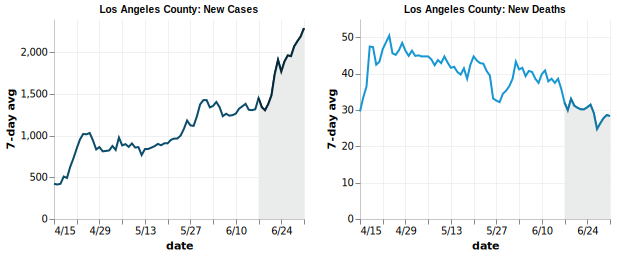

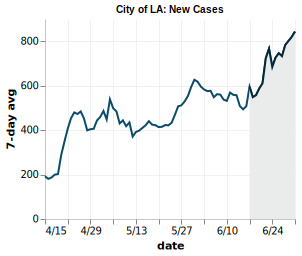

In [8]:
la_county = utils.county_case_charts(county_state_name, start_date)
la_city = utils.lacity_case_charts(start_date) 

In [9]:
display(Markdown("## Testing Charts"))
display(Markdown(
    f"These charts show the amount of daily testing conducted and the percent of tests that came back positive for COVID-19 by week since {start_date.strftime(fulldate_format)}. "
    )
)

## Testing Charts

These charts show the amount of daily testing conducted and the percent of tests that came back positive for COVID-19 by week since 4/15/20. 

#### Daily Testing
LA County's goal is to conduct an average of 15,000 tests a day, a rate of 45 tests per 1,000 residents *(lower
bound)*. Chicago, another region faced with a severe outbreak, set the precedent for regional benchmarks being more stringent than statewide requirements if a particular region underwent a more severe outbreak. Chicago's goal is 50 tests per 1,000 residents, or 16,667 tests per day *(upper bound)*. 

**The daily testing requirement is that we are conducting at least 15,000 tests daily until a vaccine is ready.** The City of LA's goal is simply half of LA County's goal; 7,500 tests and 8,339 tests as the lower and upper bounds, respectively. We need to **consistently record testing levels at or above** the lower dashed line. 

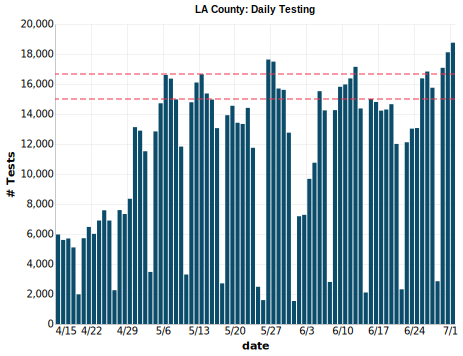

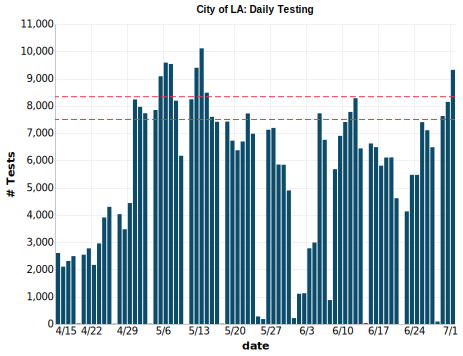

In [10]:
county_tests = utils.lacounty_testing_charts(start_date, county_test_lower_bound, county_test_upper_bound)
city_tests = utils.lacity_testing_charts(start_date, city_test_lower_bound, city_test_upper_bound)

#### Share of Positive COVID-19 Test Results by Week
Ideally, the positive/negative results per batch are calculated. Without this granular data, testing and case data are combined by week to account for any time lags. 

The chart compares the percent of positive test results, the number of positive cases, and the number of tests conducted. The percent of positive test results is the indicator of interest, but it is extremely dependent on the number of tests conducted. A higher percentage of positive tests can be due to more confirmed cases or fewer tests conducted. Therefore, the next chart shows the number of tests conducted each week (blue) and the number of positive tests (gray). It also shows the testing upper and lower bounds, which is simply the daily testing upper and lower bounds multiplied by 7.

**How to Interpret Results**
1. If the number of positive tests and the percent of positive tests increase while daily testing is conducted at a similar level, there is increased transmission of the virus.
1. If we keep up our daily testing levels yet see a corresponding drop in the share of positive tests and the number of positive cases, we are curbing the asymptomatic transmission of the virus. 
1. If daily testing drops and we see a corresponding drop in positive test results, the decrease in positive results is due to a lack of testing, not because there is less hidden, community transmission of the virus.
1. If daily testing is stable or increasing, the share of positive tests is stable or decreasing, yet the number of positive cases is growing, then our tests are finding the new cases.


**CA's weekly COVID-19 positive share requirement is that tests coming back positive is 8% or below** *(upper bound)*, but experts say that [less than 4% positive](https://www.nytimes.com/2020/05/25/health/coronavirus-testing-trump.html) is necessary to halt the spread of the virus *(lower bound)*. 

*Caveat:* Testing data is only available for tests conducted at county and city sites.  Oral swabs are used by county/city sites, which have an approximate 10% false negative rate. On average, 10% of negative tests are falsely identified to be negative when they are actually positive. We do not have information on the number of tests conducted by healthcare providers, such as Kaiser Permanente. However, we do have the number of confirmed cases. Hence, our numerator is complete, but our denominator is likely too small, leading to overestimating the share of positive results. However, LA County's own official reports of the share of positive results likely underestimate, because of the high false negative rate from the oral swabs used at all the county/city sites.

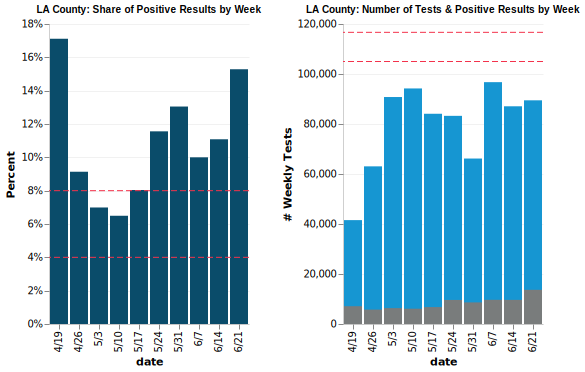

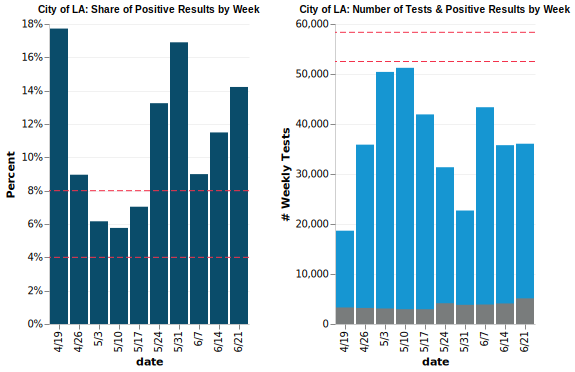

In [11]:
county_positive_tests = utils.lacounty_positive_test_charts(start_date, positive_lower_bound, positive_upper_bound, 
                                                     county_test_lower_bound, county_test_upper_bound)
city_positive_tests = utils.lacity_positive_test_charts(start_date, positive_lower_bound, positive_upper_bound,
                                                  city_test_lower_bound, city_test_upper_bound)

In [12]:
display(Markdown("## Hospital Capacity Charts"))
display(Markdown(
    f"These charts show the percent and number of available Acute Care Beds, ICU Beds, and Ventilators since {start_date.strftime(fulldate_format)}, using a 3-day rolling average. " 
    )
)

## Hospital Capacity Charts

These charts show the percent and number of available Acute Care Beds, ICU Beds, and Ventilators since 4/15/20, using a 3-day rolling average. 

The hospital equipment data comes from a daily HavBed survey of the 70 largest hospitals in the county. While it is a subset of all hospitals, it represents the majority of our countywide hospital capacity. 

#### Hospital Equipment Availability
LA County's goal is have 20% of available ventilators and 10% ICU beds available in case of any potential surge in hospitalizations. New York City, the region faced with the most severe outbreak, set a benchmark of having at least 30% of hospital equipment available. LA County's own goal of 10% ICU beds available is far too low; we've hovered around 10% of ICU beds available since 4/15/20. Arguably, proof that the virus is indeed decreasing should mean more ICU beds freed up as we move toward reopening and preparing for any potential surge.

The percentage of available equipment must be shown alongside the number of available equipment. An increase in the percent of available equipment must be matched with an increase in the number of available equipment for adequate preparation against a future surge. An increase in the percent of available equipment accompanied by a decrease in the number of available equipment simply means we have *more* of our *smaller* pool of resources. Constant denominators are used: 17,000 Acute Care Beds, 2,500 ICU Beds, and 3,200 Ventilators.

CA guidelines state that hospitals must be able to accommodate a minimum surge of 35% due to COVID-19 patients, in addition to providing usual care for non-COVID-19 patients. To adjust for our HavBed data only covering the 70 largest hospitals in the county, the **hospital equipment requirement is set at 30%.** 

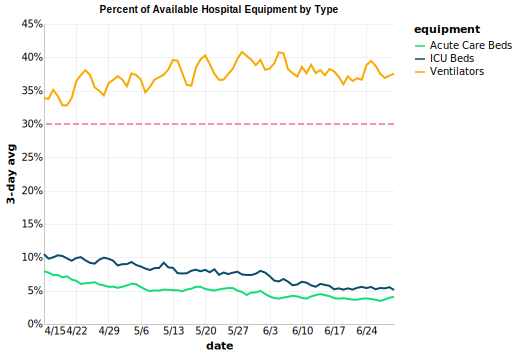

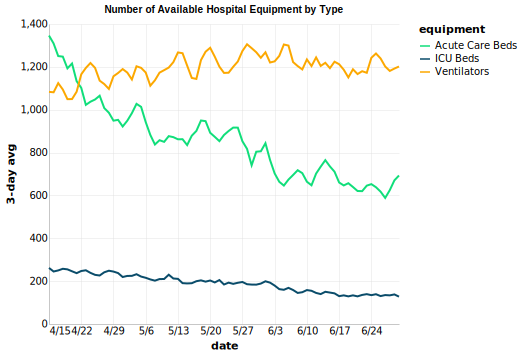

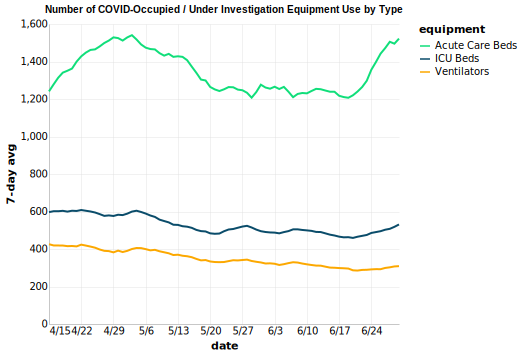

In [13]:
hospital = utils.lacounty_hospital_charts(start_date)

#### COVID Hospitalizations
Data on all COVID-related hospitalizations and ICU hospitalizations comes from the CA open data portal made available 6/25/20; this data should cover the entire county.

CA guidelines state that hospitalizations should be stable or downtrending on 7-day average of daily percent change of less than 5%. LA County's all COVID-related hospitalizations and COVID-related ICU hospitalizations (subset of all hospitalizations) are shown. 

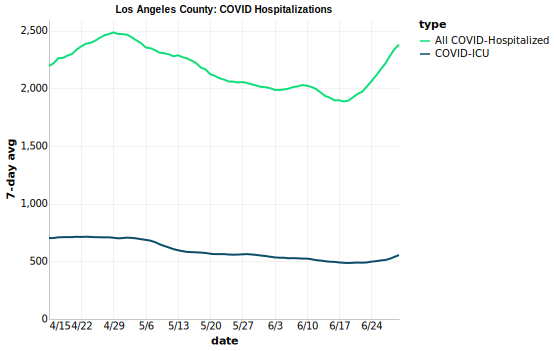

In [14]:
hospitalizations = utils.county_covid_hospital_charts(county_state_name, start_date)

If you have any questions, please email ITAData@lacity.org.